In [1]:
# 과거&현재 일별 주가와 거래량(time series형태)을 이용하여 내일의 주가를 예측한다

# 실험적 경험 교훈
# 1) LSTM셀 활성화함수는 tanh보다 softsign가 조금 더 안정적이고 좋은 결과를 얻는다
# 2) LSTM은 AdamOptimizer 최적화 함수 추천
# 3) LSTM은 구조상 DropoutWrapper와 궁합이 안맞다
# 3) RNN에서 데이터 특성에 맞는 sequence length가 중요하다! 상황에 따라...
#    아마존 주가의 경우 대체적으로 긴 기간이 더 좋으나 너무 긴 것보다 28거래일이 더 좋게 나왔다
# 4) input_data_column_cnt(입력데이터의 컬럼 개수)가 적은 경우 stacked RNN을 사용하면 빠르게 Over Fitting된다
# 5) rnn_cell_hidden_dim(각 셀의 (hidden)출력 크기)가 많은 경우 너무 많으면 오래걸리고 추가 개선은 거의 없다

# TO-DO 리스트
#            조기종료(early stopping) 조건을 넣어 과적합발생 시 중단로직 추천
#            학습률(learning rate)을 상황에 따라 조정할 것

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

C:\Python\Anaconda3-52\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)

In [4]:
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [5]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [6]:
# 데이터를 로딩한다.
stock_file_name = 'AMZN.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv('data/AMZN.csv', names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
Date         5179 non-null object
Open         5179 non-null object
High         5179 non-null object
Low          5179 non-null object
Close        5179 non-null object
Adj Close    5179 non-null object
Volume       5179 non-null object
dtypes: object(7)
memory usage: 283.3+ KB
stock_info.shape:  (5178, 6)
stock_info[0]:  [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]


In [7]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다

# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용

y = x[:, [-2]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

price.shape:  (5178, 5)
price[0]:  [2.4375   2.5      1.927083 1.958333 1.958333]
norm_price[0]:  [0.00092814 0.00097971 0.00050704 0.00053282 0.00053282]
volume.shape:  (5178, 1)
volume[0]:  [72156000.]
norm_volume[0]:  [0.69017161]
x.shape:  (5178, 6)
x[0]:  [9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
 5.32822633e-04 6.90171607e-01]
x[-1]:  [0.96451605 0.96645482 0.95354329 0.95758589 0.95758589 0.02142033]
y[0]:  [0.00053282]
y[-1]:  [0.95758589]


In [8]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
  5.32822633e-04 6.90171607e-01]
 [5.41416826e-04 5.50011019e-04 3.26568604e-04 3.43756990e-04
  3.43756990e-04 1.36869475e-01]
 [3.69538744e-04 3.78132112e-04 2.57817536e-04 3.26568604e-04
  3.26568604e-04 5.41168313e-02]
 [3.43756990e-04 3.60944551e-04 2.66411729e-04 2.66411729e-04
  2.66411729e-04 4.79574739e-02]
 [2.66411729e-04 2.75005097e-04 5.15635073e-05 9.45328216e-05
  9.45328216e-05 1.76864852e-01]
 [1.03127015e-04 1.11721207e-04 0.00000000e+00 6.87510680e-05
  6.87510680e-05 1.08719015e-01]
 [7.73452609e-05 1.71878083e-04 1.71875607e-05 1.54690522e-04
  1.54690522e-04 1.48783729e-01]
 [1.63284715e-04 2.75005097e-04 1.20314575e-04 2.23441590e-04
  2.23441590e-04 7.90662738e-02]
 [2.57817536e-04 2.66411729e-04 1.80472275e-04 1.80472275e-04
  1.80472275e-04 3.93597966e-02]
 [1.89066468e-04 1.89066468e-04 1.37502961e-04 1.58987206e-04
  1.58987206e-04 2.87513723e-02]
 [1.54690522e-04 1.63284715e-04 1.37502961e-04 1.5

In [9]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [10]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [11]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

hypothesis:  Tensor("rnn/transpose:0", shape=(?, 28, 20), dtype=float32)


In [12]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [13]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.0027808304876089096, test_error(B): 0.07090393453836441, B-A: 0.06812310218811035
epoch: 200, train_error(A): 0.0026550001930445433, test_error(B): 0.04247162118554115, B-A: 0.03981662169098854
epoch: 300, train_error(A): 0.0025644584093242884, test_error(B): 0.03214874491095543, B-A: 0.029584286734461784
epoch: 400, train_error(A): 0.0024856110103428364, test_error(B): 0.024813219904899597, B-A: 0.022327609360218048
epoch: 500, train_error(A): 0.002415049122646451, test_error(B): 0.01907806098461151, B-A: 0.01666301116347313
epoch: 600, train_error(A): 0.0023507894948124886, test_error(B): 0.01499003916978836, B-A: 0.012639249674975872
epoch: 700, train_error(A): 0.0022911187261343002, test_error(B): 0.01246388629078865, B-A: 0.01017276756465435
epoch: 800, train_error(A): 0.0022346454206854105, test_error(B): 0.010709214024245739, B-A: 0.008474568836390972
epoch: 900, train_error(A): 0.002181165385991335, test_error(B): 0.009184680879116058,

In [14]:
test_predict

array([[0.19964226],
       [0.19484438],
       [0.19167767],
       ...,
       [0.9397444 ],
       [0.94157   ],
       [0.94698054]], dtype=float32)

input_data_column_cnt: 6,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.0021320037,test_error: 0.008298757,min_test_error: 0.008298757


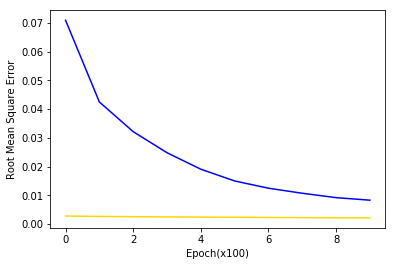

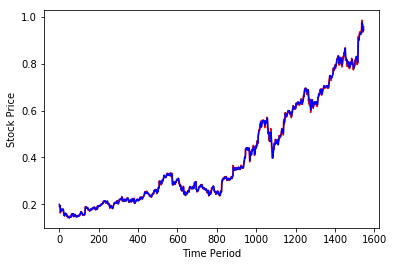

In [14]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [15]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 28, 6)
recent_data: [[[0.91386004 0.9151306  0.90735891 0.910791   0.910791   0.02879182]
  [0.91089    0.91383526 0.90374533 0.909471   0.909471   0.03147378]
  [0.90462816 0.90803538 0.89560243 0.90166628 0.90166628 0.0307939 ]
  [0.89913352 0.91689614 0.89696373 0.91600506 0.91600506 0.03143526]
  [0.91398381 0.92739858 0.9136703  0.92347976 0.92347976 0.0278683 ]
  [0.92684578 0.93168037 0.92087268 0.92555055 0.92555055 0.02120337]
  [0.92526172 0.935756   0.92220094 0.93356143 0.93356143 0.02016814]
  [0.92785228 0.93087187 0.91944541 0.93046762 0.93046762 0.03125421]
  [0.92796779 0.93262916 0.92628483 0.92734903 0.92734903 0.01630073]
  [0.92541026 0.93935306 0.92486573 0.93050065 0.93050065 0.02341249]
  [0.93127612 0.93778551 0.92614454 0.93682846 0.93682846 0.0255311 ]
  [0.92871859 0.93262916 0.92428    0.92845453 0.92845453 0.0331417 ]
  [0.93131741 0.93791754 0.93122667 0.93719978 0.93719978 0.01662237]
  [0.93801653 0.93844556 0.92772861 0.93108638 